# Data Science Project

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
url <- "https://drive.google.com/uc?export=download&id=1kBbW3nLa_kBrNruxi2itBmCwvUT29w8b" 
players_df <- read_csv(url)
head(players_df)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Introduction:
### Data Description:



## Methods:




In [20]:
#summary of data set values that are relevant for exploratory analysis 
players_values <- players_df |>
  summarize(
    max_played_hours = max(played_hours),
    max_age = max(Age, na.rm = TRUE),
    min_played_hours = min(played_hours),
    min_age = min(Age, na.rm = TRUE),
    mean_played_hours = mean(played_hours),
    mean_age = mean(Age, na.rm = TRUE))

players_values



max_played_hours,max_age,min_played_hours,min_age,mean_played_hours,mean_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223.1,50,0,8,5.845918,20.52062


In [21]:
#data wrangling
players_data_new <- players_df|>
rename(hashed_email = hashedEmail, age = Age) |>
filter(played_hours < 150.0, age != "NA") |>
select(played_hours, age,subscribe) |>
arrange(desc(played_hours))
head(players_data_new)

#mutate the response variable into factor data type
players_mutate<-players_data_new|>
mutate(subscribe=as_factor(subscribe))

head(players_mutate)

played_hours,age,subscribe
<dbl>,<dbl>,<lgl>
56.1,23,TRUE
53.9,17,TRUE
48.4,17,TRUE
32.0,22,TRUE
30.3,9,TRUE
23.7,24,TRUE


played_hours,age,subscribe
<dbl>,<dbl>,<fct>
56.1,23,TRUE
53.9,17,TRUE
48.4,17,TRUE
32.0,22,TRUE
30.3,9,TRUE
23.7,24,TRUE


explain what we did^ 

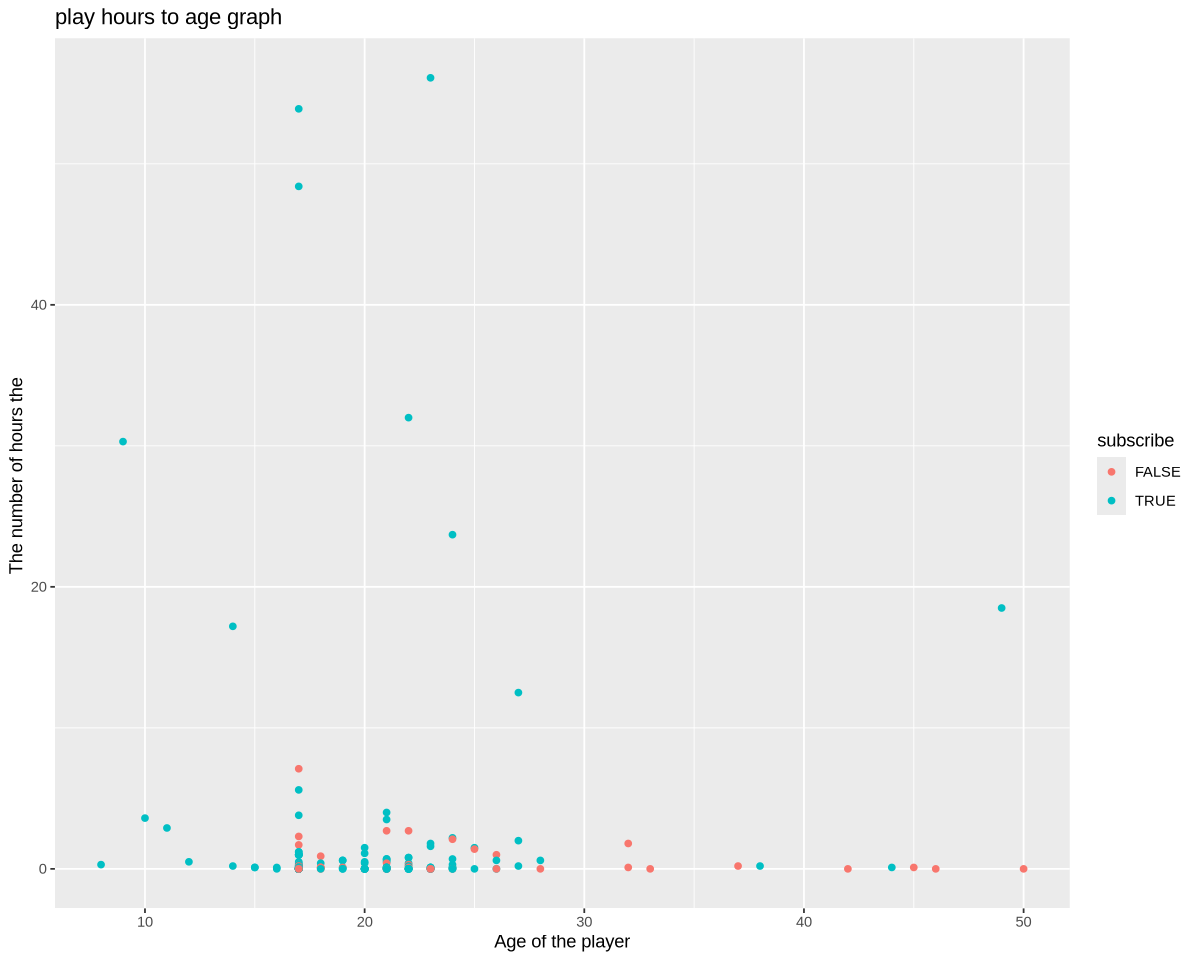

In [27]:
options(repr.plot.width = 10, repr.plot.height = 8)
hours_to_age_plot <- players_mutate |>
   ggplot(aes(x = age, y = played_hours, color = subscribe)) + 
       geom_point(alpha = 1) + # Deals with the transparency of the points, set it to an appropiate value
        xlab("Age of the player") +
        ylab("The number of hours the ") +
       ggtitle("play hours to age graph")

hours_to_age_plot

The scatter plot above was made to determine if there was a relationship between the players age and how many hours they spent playing games. Based on this graph, the results are inconclusive as theres no clear trend amongst the two variables. As illustrated by the plot, the players age ranged from around 5 years old to 50, but majority of the points are positioned towards the bottom of the plot, suggesting that regardless of the individuals age, they all had relatively the same amount of playing time, despite a few points scattered towards the top of the plot. The data is also slighlty difficult to analyze desipte adding colour and changining the size of the plot because majority of the indivdiuals in the data had playing hours like 1.2, 1.3, 1.6, etc so many of the points are positioned towards the bottom of the plot. Overall, the graph shows no correlation between playing time and age, therefore, this relationship will not help to adresss the research question.
- CHANGE WORDING
- why we choose scatter plot
- what were gonna do next

In [28]:
set.seed(3456) 
#explain more of what were doing using #
#data_wrangling scaled values 
# Randomly take 75% of the data in the training set. 
# This will be proportional to the different number of subscribe in the dataset.

players_df_split <- initial_split(players_mutate, prop = 0.75, strata = subscribe)  
players_df_train <- training(players_df_split)
players_df_test <- testing(players_df_split)

head(players_df_train)
head(players_df_test)


played_hours,age,subscribe
<dbl>,<dbl>,<fct>
7.1,17,FALSE
2.7,22,FALSE
2.7,21,FALSE
2.1,24,FALSE
1.8,32,FALSE
1.7,17,FALSE


played_hours,age,subscribe
<dbl>,<dbl>,<fct>
48.4,17,TRUE
32.0,22,TRUE
30.3,9,TRUE
23.7,24,TRUE
18.5,49,TRUE
5.6,17,TRUE


In [29]:
#making a recpie and scaling the data
players_recipe <- recipe(subscribe ~ played_hours + age, data = players_df_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors()) 

players_recipe_scaled <- players_recipe |>
prep() |>
bake(players_df_train)
head(players_recipe_scaled)

played_hours,age,subscribe
<dbl>,<dbl>,<fct>
0.83971134,-0.62528194,FALSE
0.18545065,0.17752127,FALSE
0.18545065,0.01696063,FALSE
0.09623329,0.49864256,FALSE
0.05162460,1.78312770,FALSE
0.03675504,-0.62528194,FALSE


explain why we scaled(especially for age variable)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.4315545,5,0.04797866,Preprocessor1_Model01
3,accuracy,binary,0.5145594,5,0.03965841,Preprocessor1_Model02
4,accuracy,binary,0.5066411,5,0.03995609,Preprocessor1_Model03
5,accuracy,binary,0.5562032,5,0.02643070,Preprocessor1_Model04
6,accuracy,binary,0.5630998,5,0.03112091,Preprocessor1_Model05
7,accuracy,binary,0.5975826,5,0.04151660,Preprocessor1_Model06
8,accuracy,binary,0.5978289,5,0.03593190,Preprocessor1_Model07
9,accuracy,binary,0.5970717,5,0.04415613,Preprocessor1_Model08
10,accuracy,binary,0.5970717,5,0.03991297,Preprocessor1_Model09


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


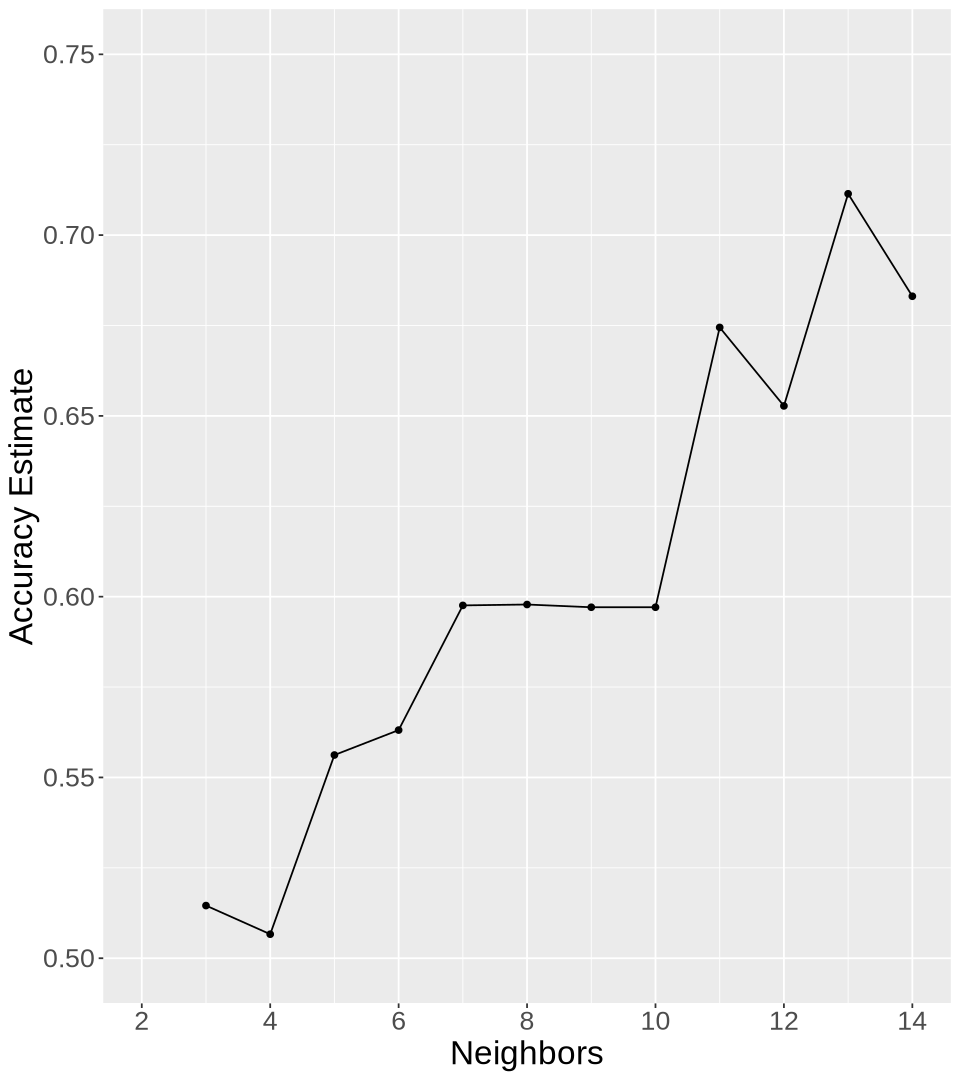

In [16]:
# Set the seed. 
set.seed(1234) 

options(repr.plot.height = 9, repr.plot.width = 8)

### Cross-Validation to select k value
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

players_vfold <- vfold_cv(players_df_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
                 add_recipe(players_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = players_vfold, grid = tibble(neighbors = c(2:14))) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')
accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 20)) +
                  scale_x_continuous(breaks = seq(0, 20, 2)) +
                  scale_y_continuous(limits = c(0.5, 0.75))

cross_val_plot


- make the model
- fit the data
- make predcitions

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = players_df_train)
players_fit

with nearest neighbors that we found (k=13)

- making predications

mnist_predictions <- predict(mnist_fit, testing_set) |>
                        bind_cols(testing_set)

mnist_metrics <- mnist_predictions |> metrics(truth = y, estimate = .pred_class)

mnist_conf_mat <- mnist_predictions |>
                        conf_mat(truth = y, estimate = .pred_class) 
mnist_metrics
mnist_conf_mat




In [30]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = players_df_train)
players_fit

players_predictions <- predict(players_fit, players_df_test) |>
                        bind_cols(players_df_test)

players_metrics <- players_predictions |> metrics(truth = subscribe, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
players_metrics
players_conf_mat

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2816901
Best kernel: rectangular
Best k: 13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6458333
kap,binary,-0.1460674


          Truth
Prediction FALSE TRUE
     FALSE     0    4
     TRUE     13   31

we need to make a visualization of the data analysis ^^^^ and add more visualization and explanations for each